# Data loading


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/cleaned_logistics_data.csv')  # Replace 'your_dataset.csv' with the actual file path

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 5 Rows:")
print(df.head())


Dataset Shape: (144867, 38)

Columns: Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor',
       'trip_duration', 'distance_covered', 'day_of_week', 'day_of_month',
       'trip_duration_outlier', 'actual_distance_to_destination_outlier',
       'actual_time_outlier', 'osrm_time_outlier', 'osrm_distance_outlier',
       'factor_outlier', 'segment_actual_time_outlier',
       'segment_osrm_time_outlier', 'segment_osrm_distance_outlier',
       'segment_factor_outlier'],
      dtype='object')

Data Types:
data                                       object
trip_c

# Exploratory Data Analysis (EDA)


Dataset Summary:
       start_scan_to_end_scan  cutoff_factor  actual_distance_to_destination  \
count           144867.000000  144867.000000                   144867.000000   
mean               961.262986     232.926567                        0.117321   
std               1037.012769     344.755577                        0.179828   
min                 20.000000       9.000000                        0.000000   
25%                161.000000      22.000000                        0.007483   
50%                449.000000      66.000000                        0.029777   
75%               1634.000000     286.000000                        0.144757   
max               7898.000000    1927.000000                        1.000000   

         actual_time      osrm_time  osrm_distance         factor  \
count  144867.000000  144867.000000  144867.000000  144867.000000   
mean        0.090190       0.123731       0.119008       0.025583   
std         0.132236       0.183340       0.181737    

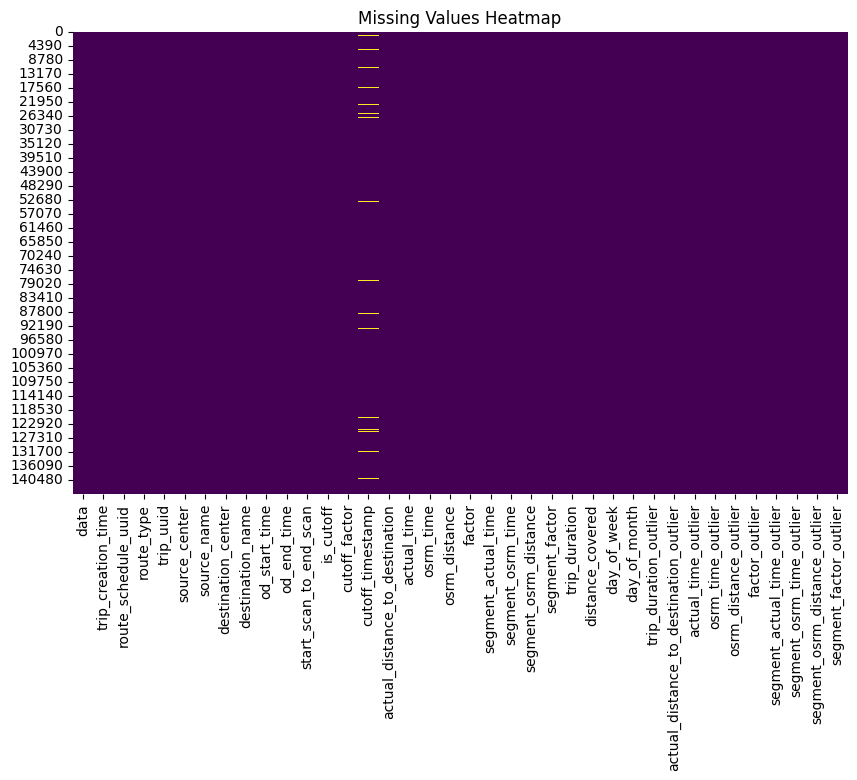

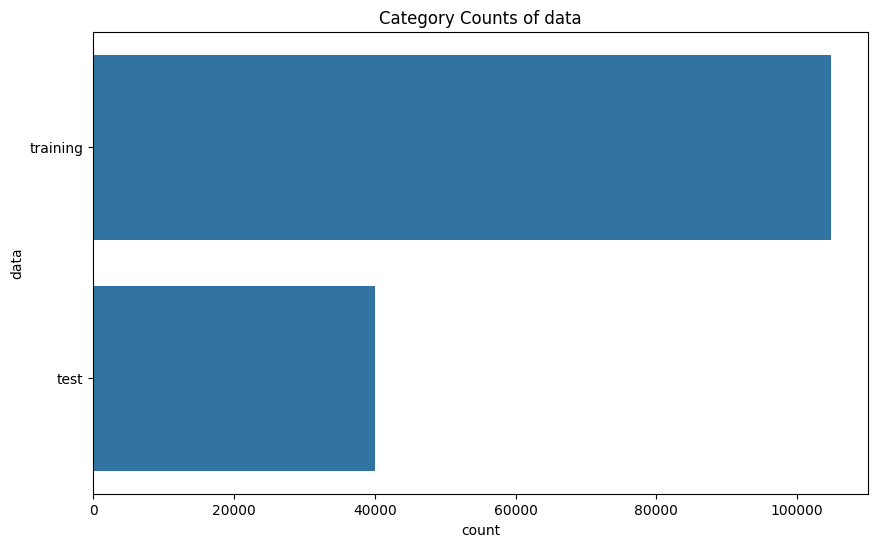

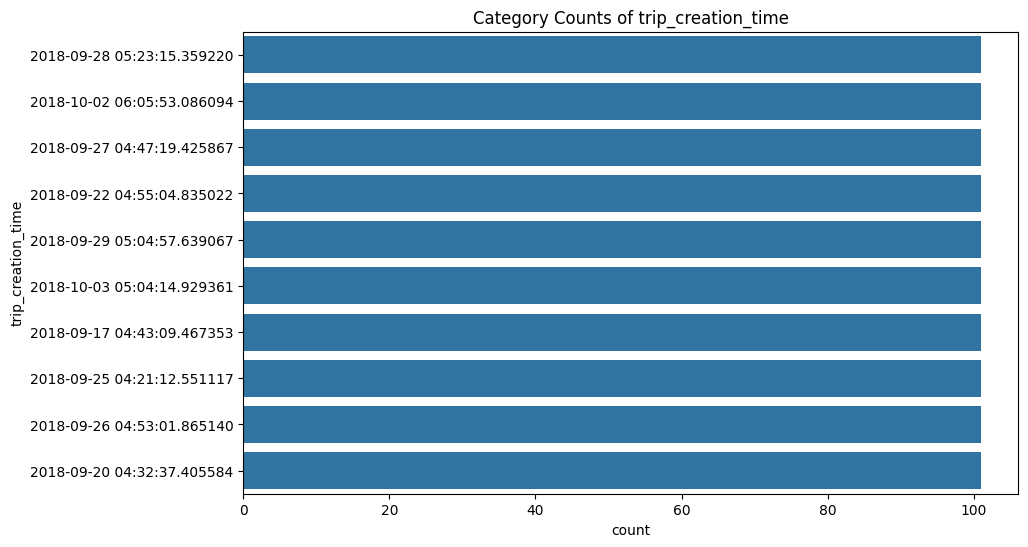

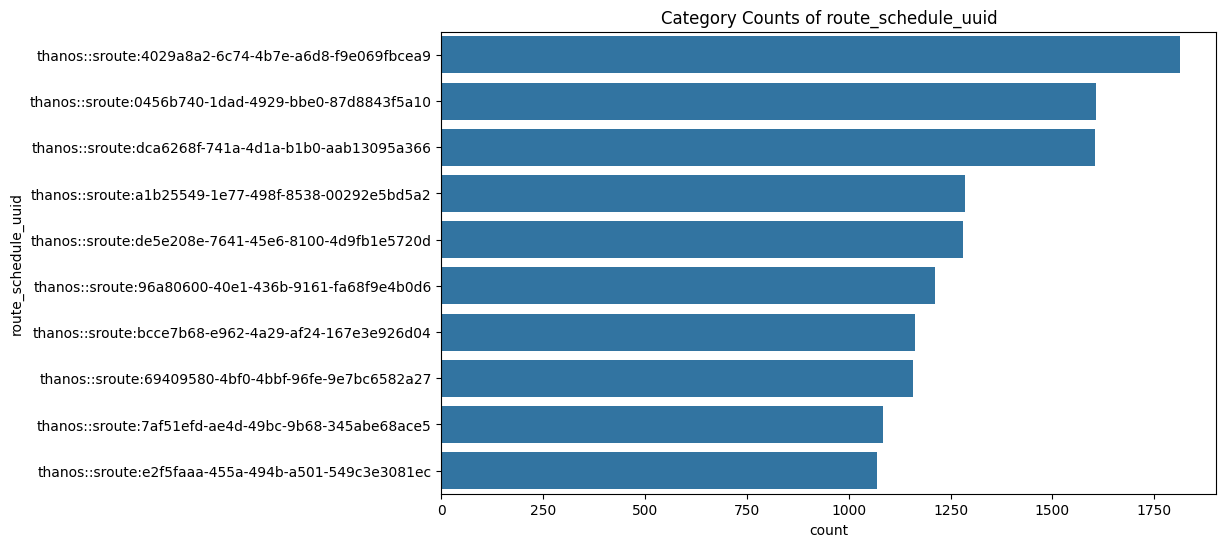

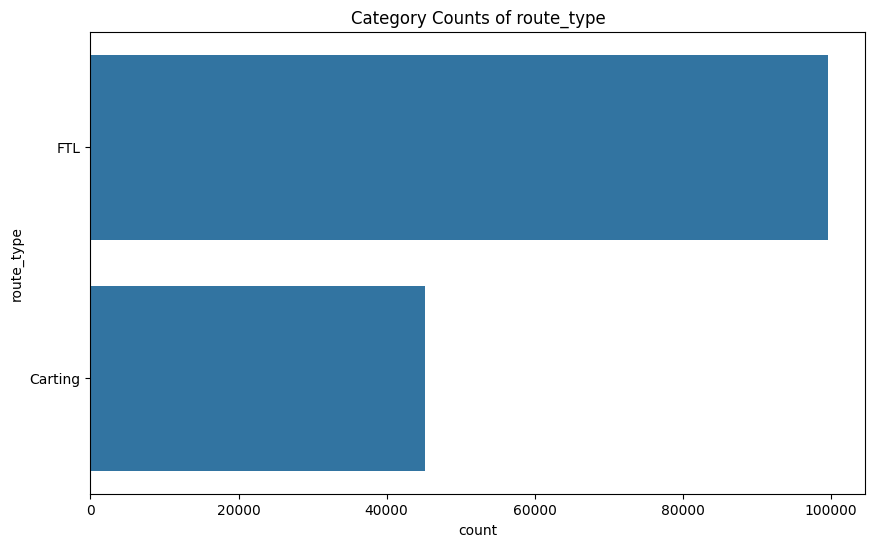

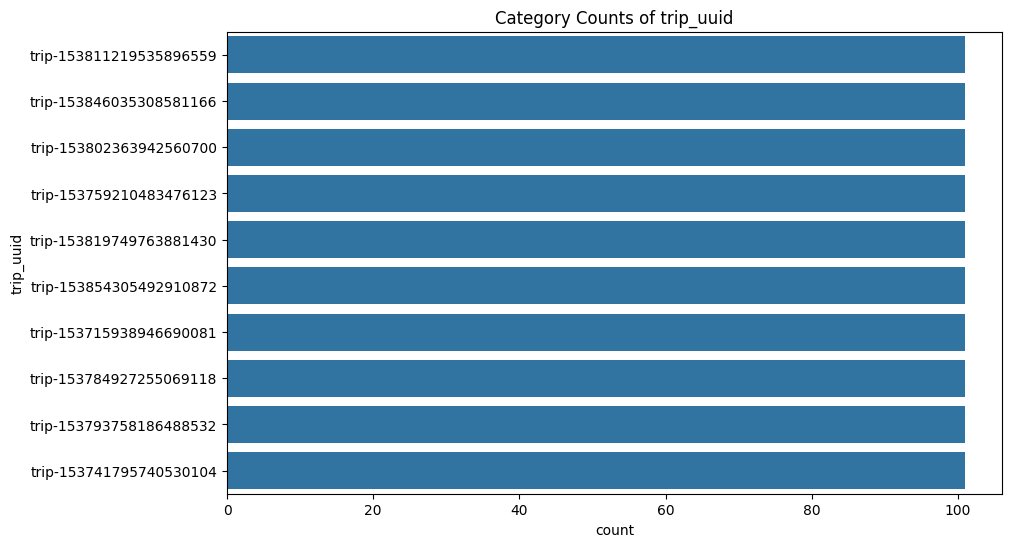

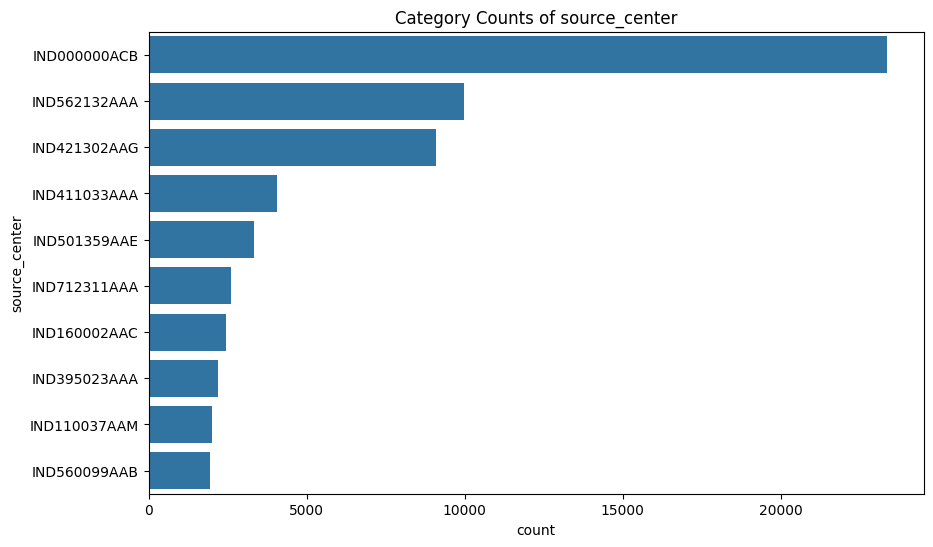

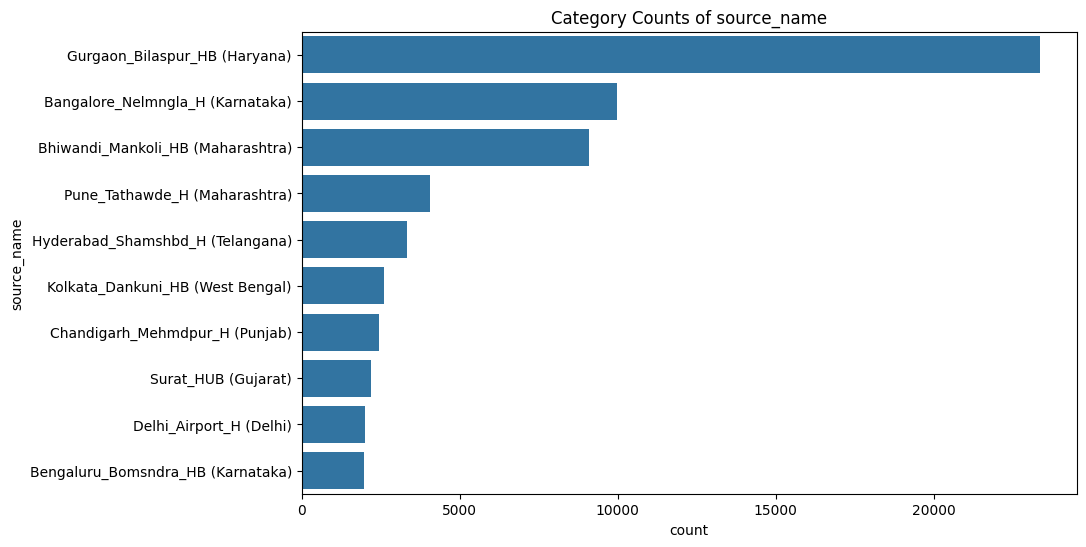

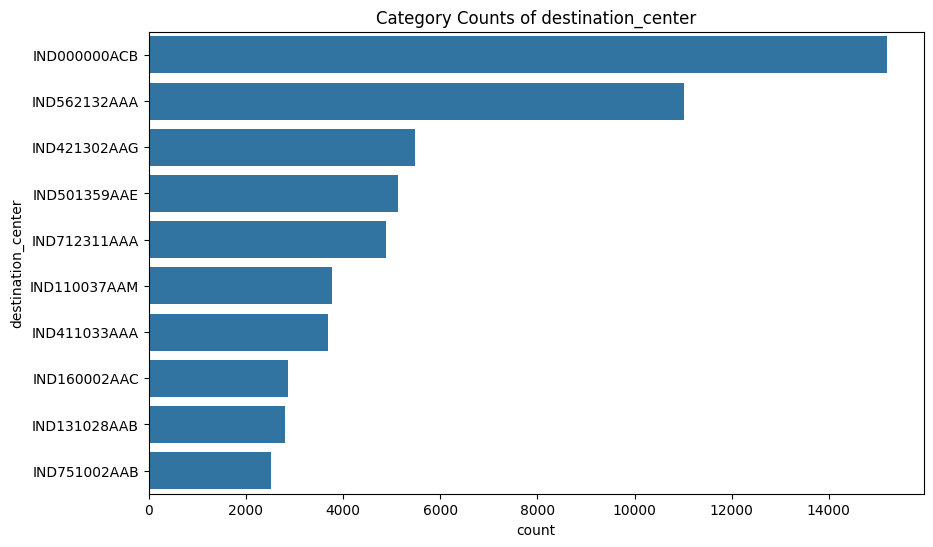

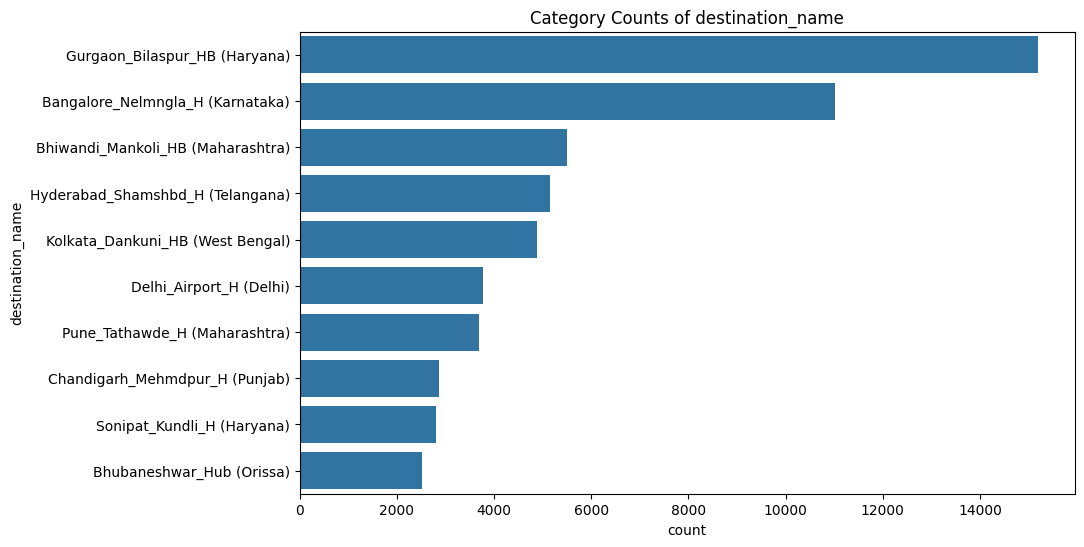

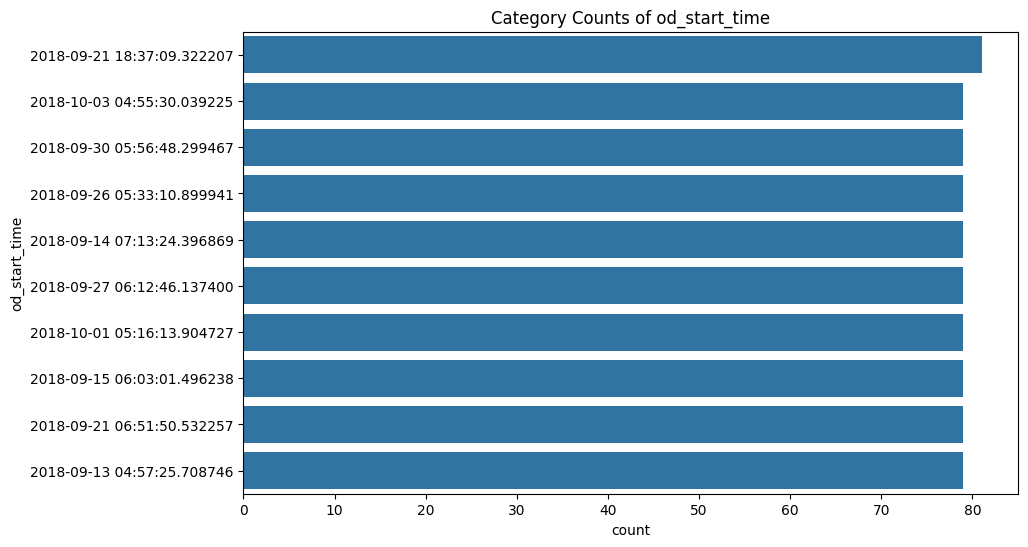

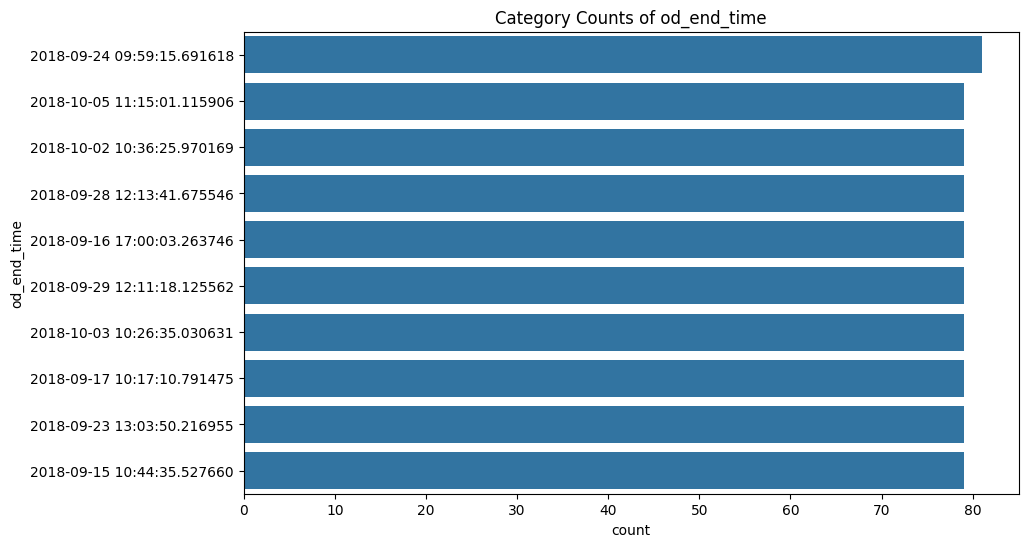

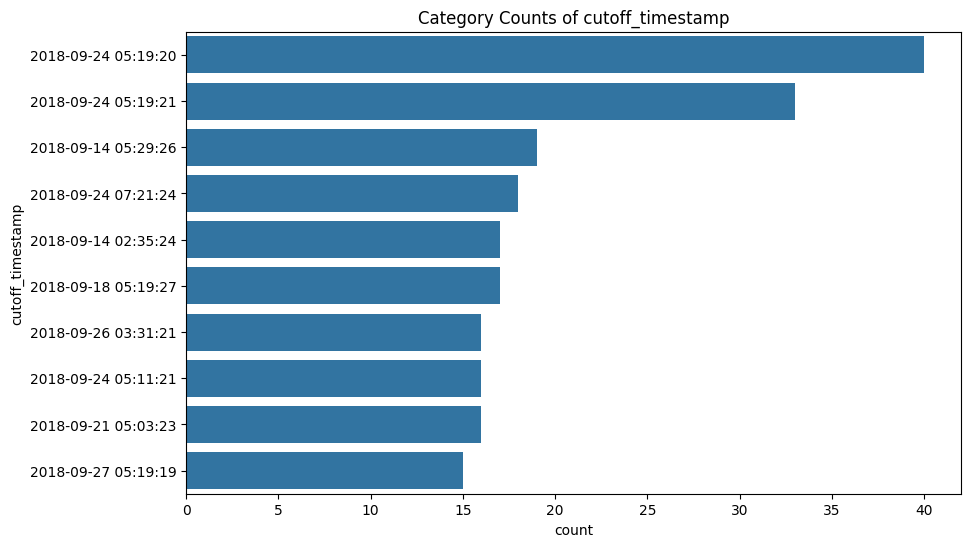

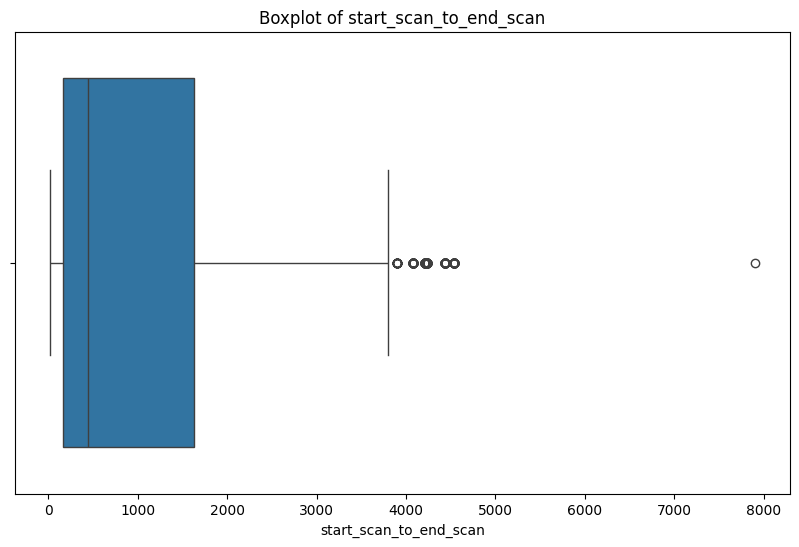

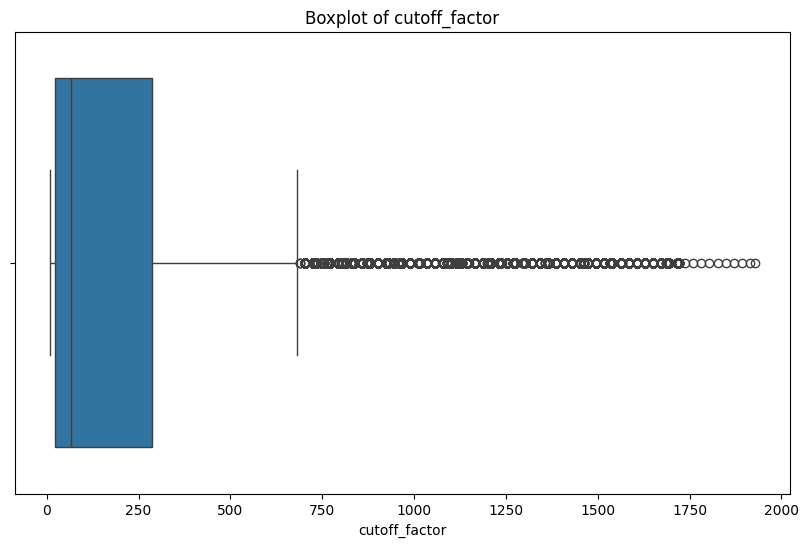

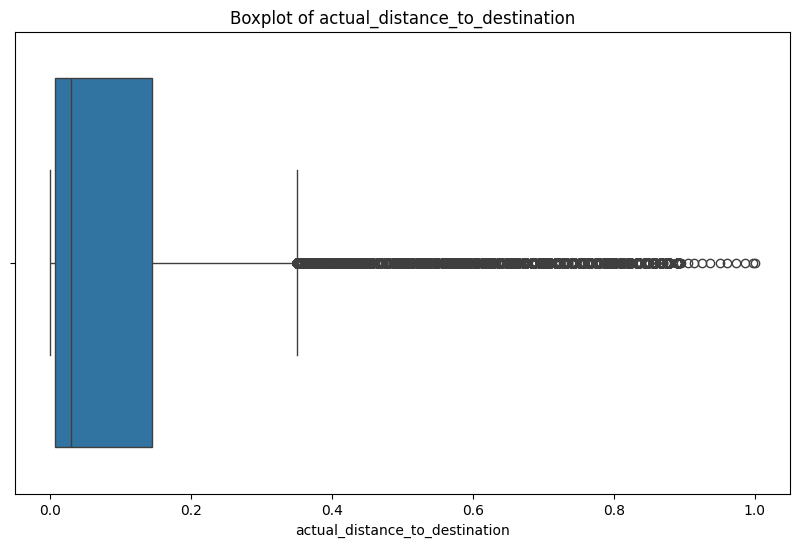

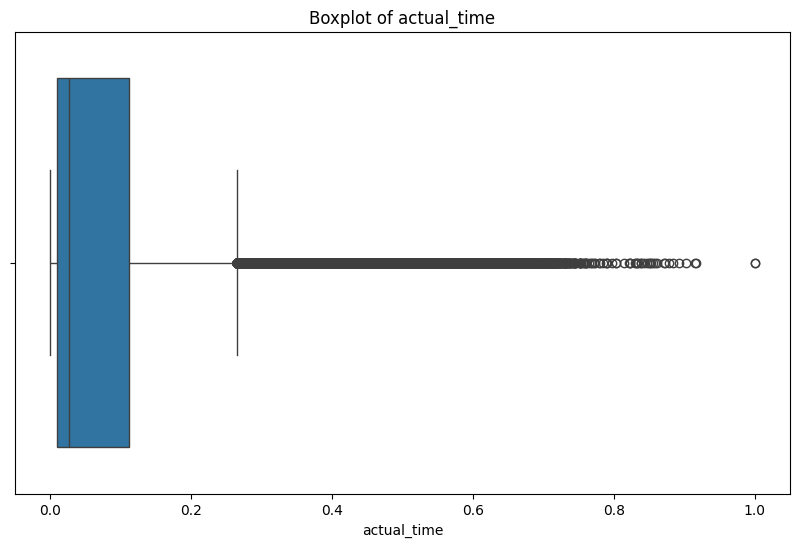

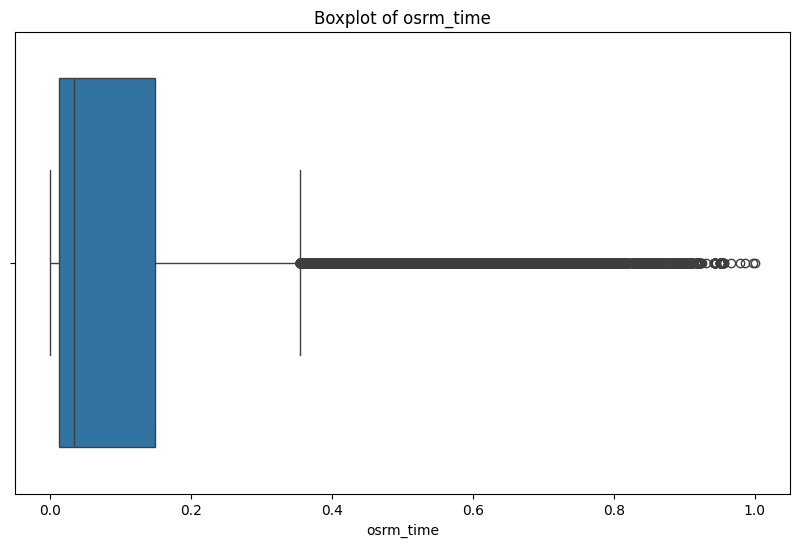

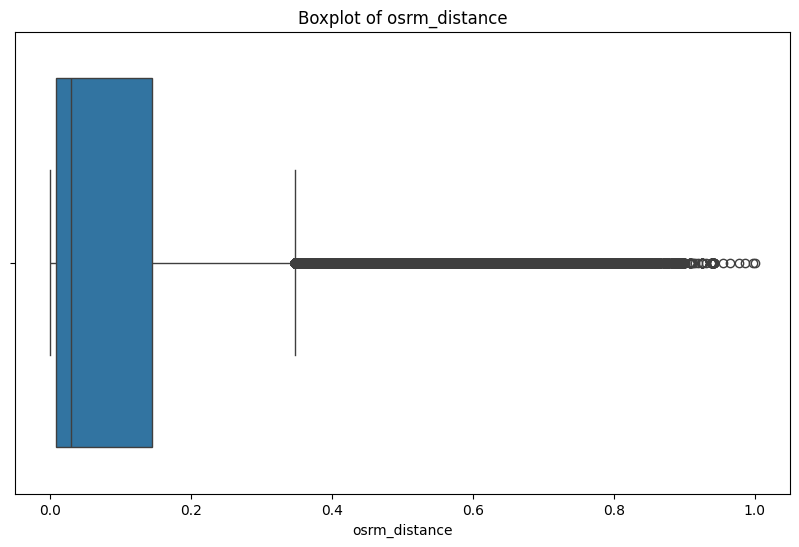

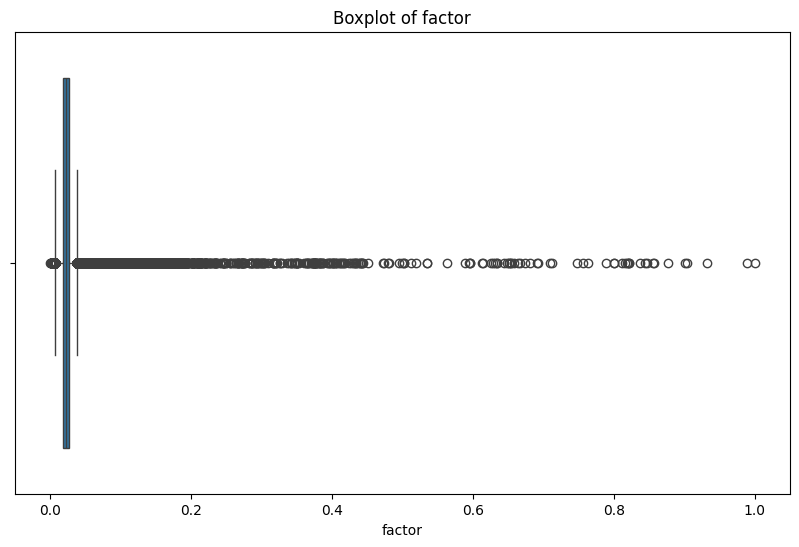

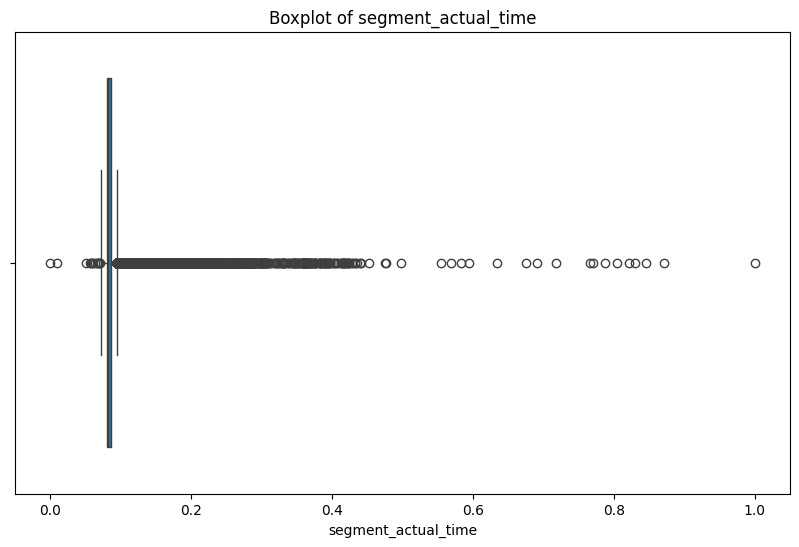

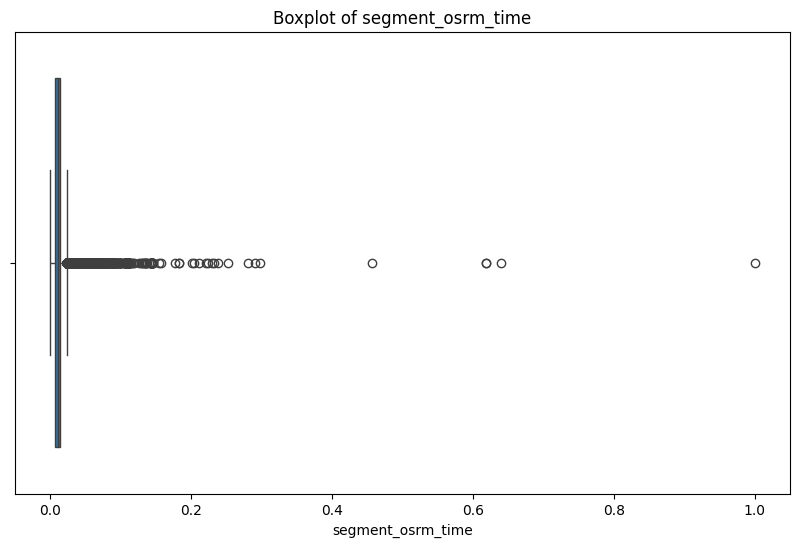

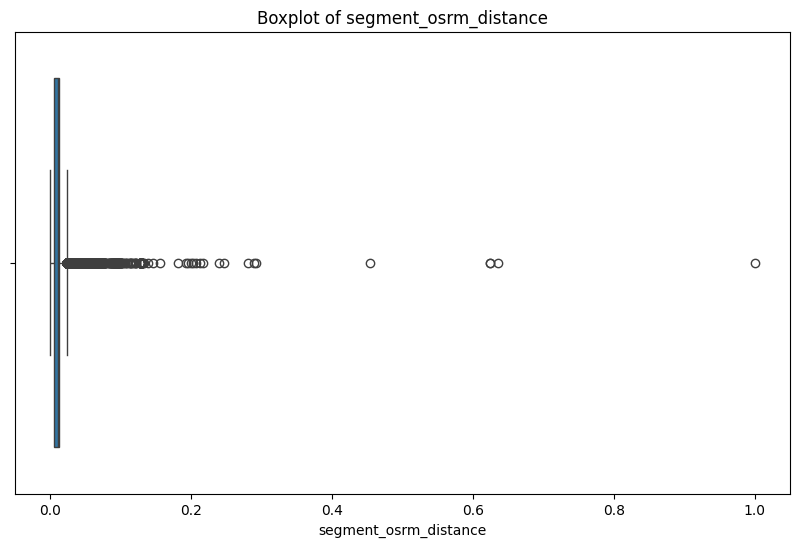

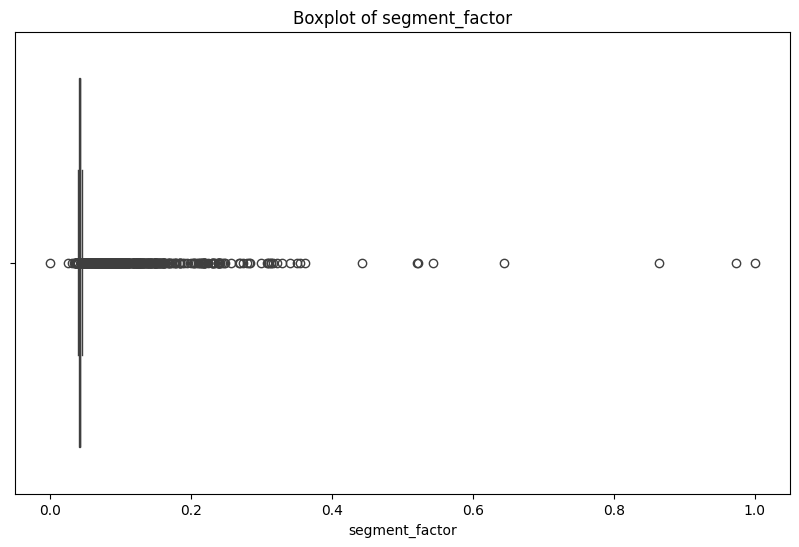

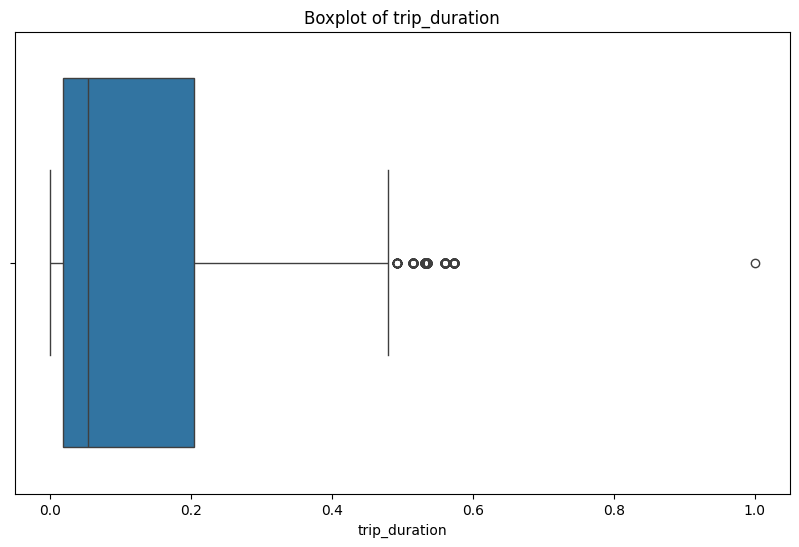

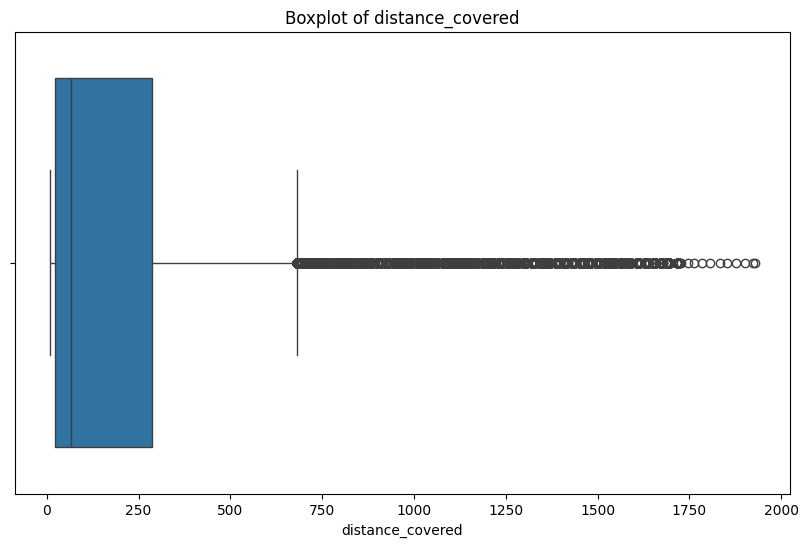

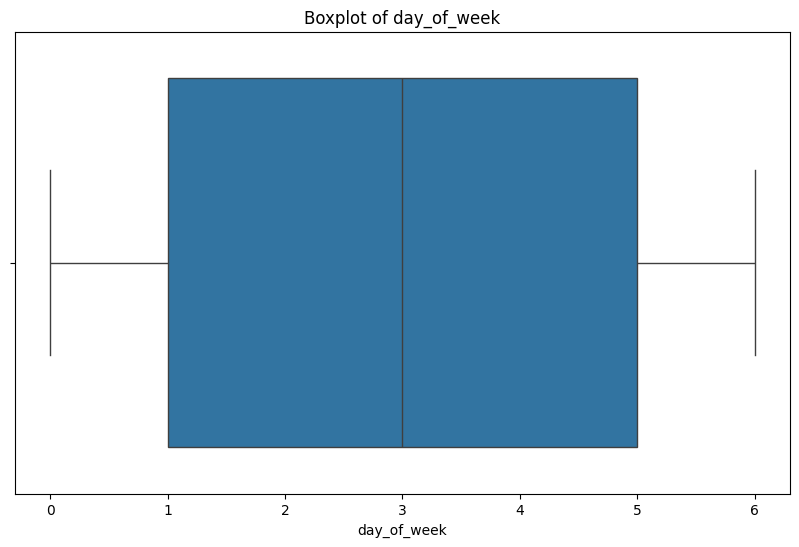

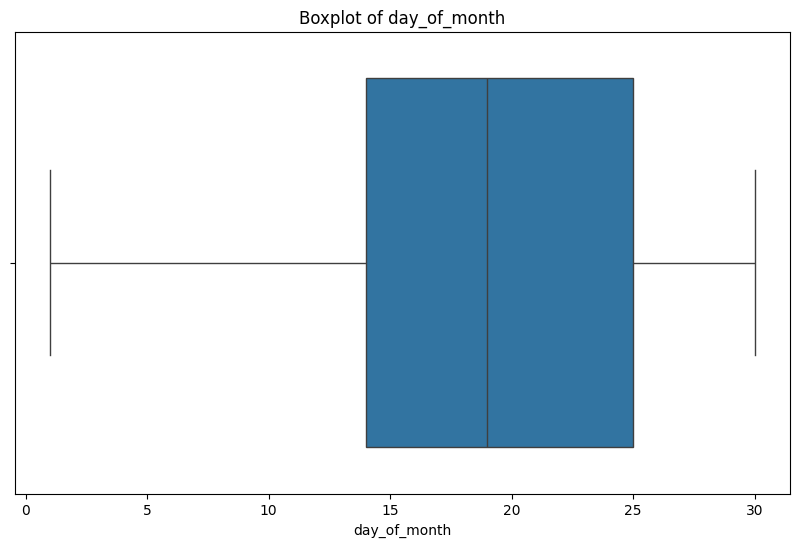

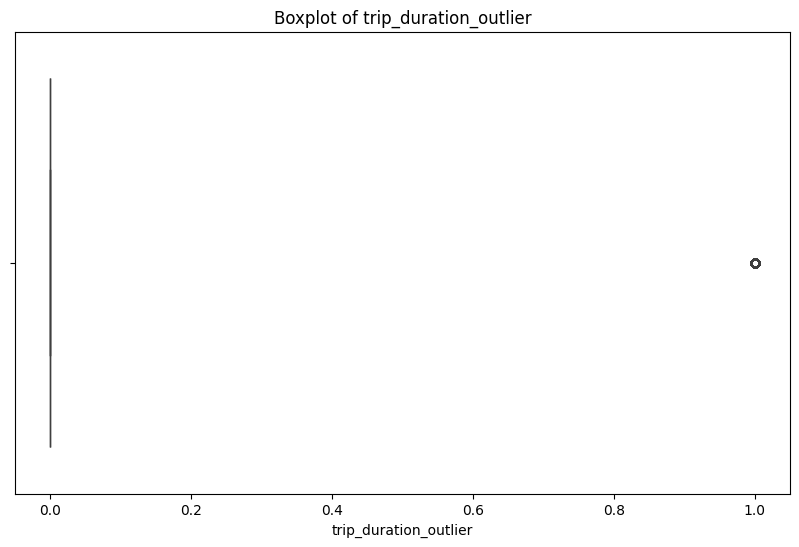

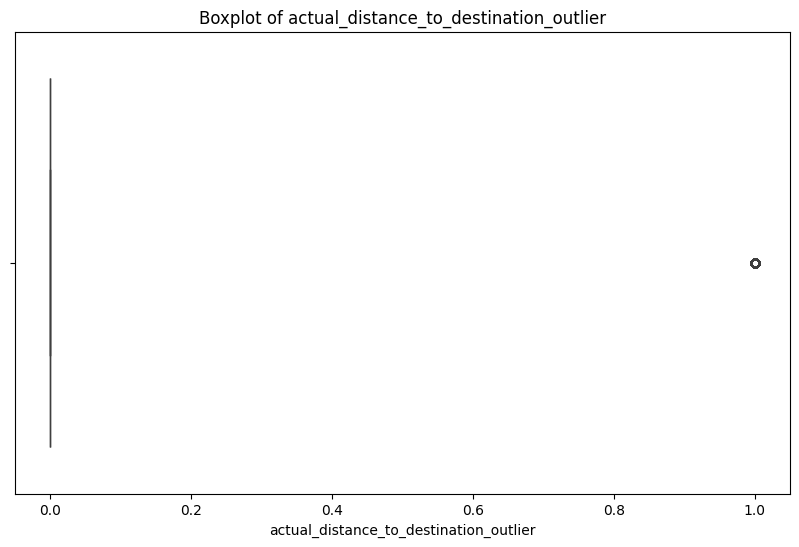

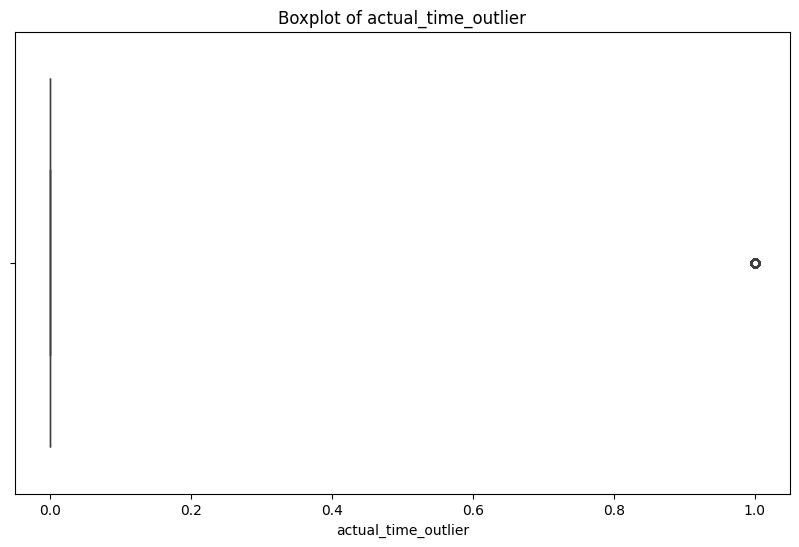

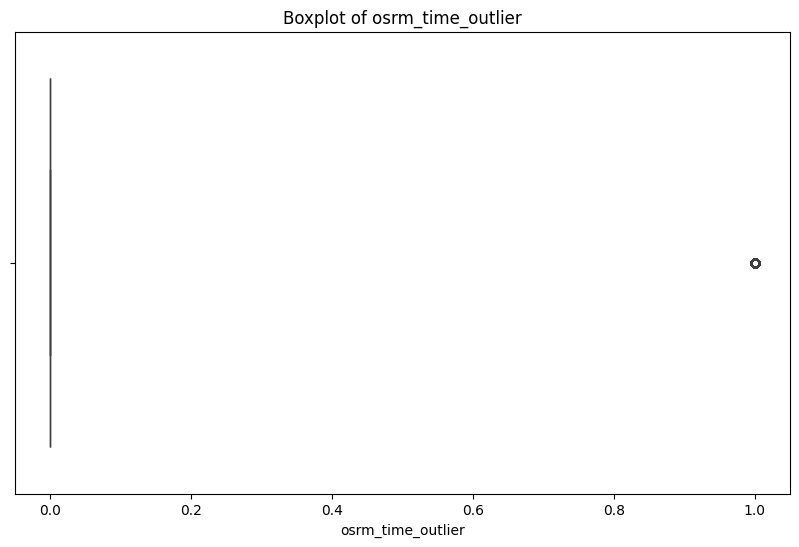

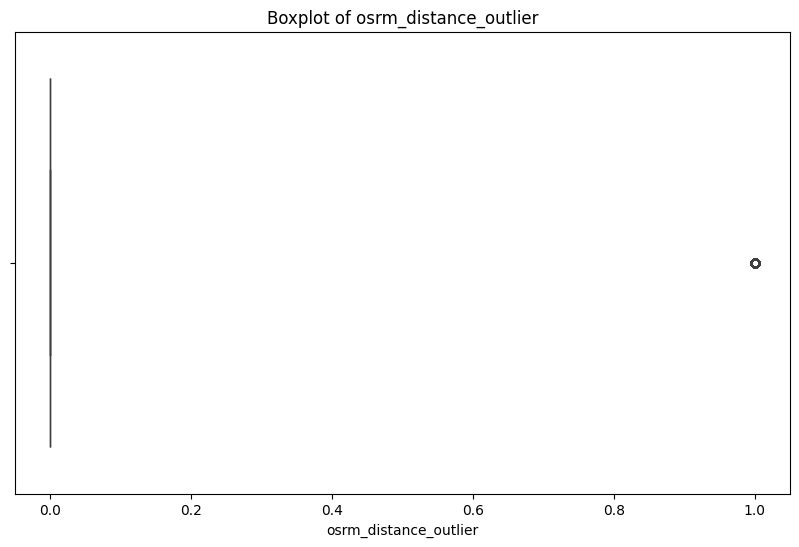

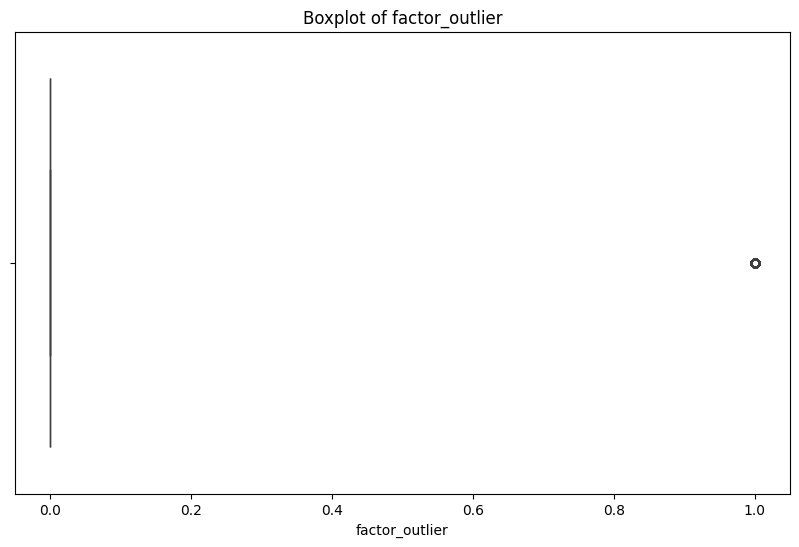

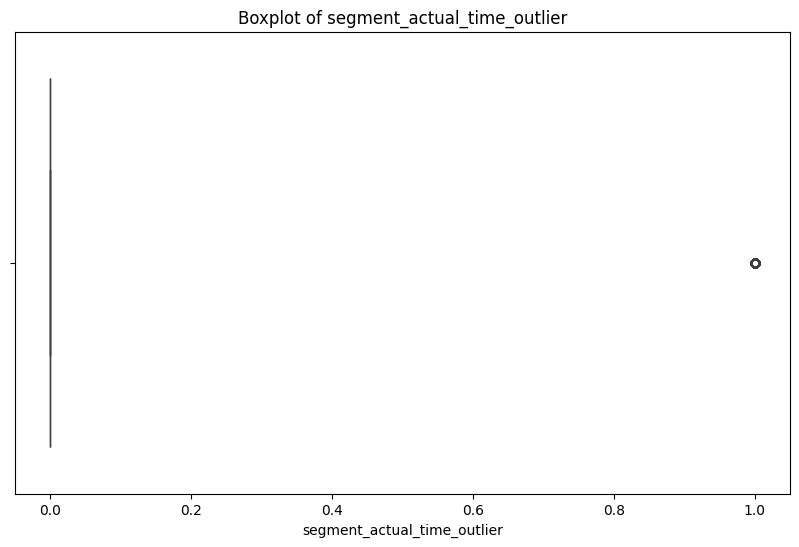

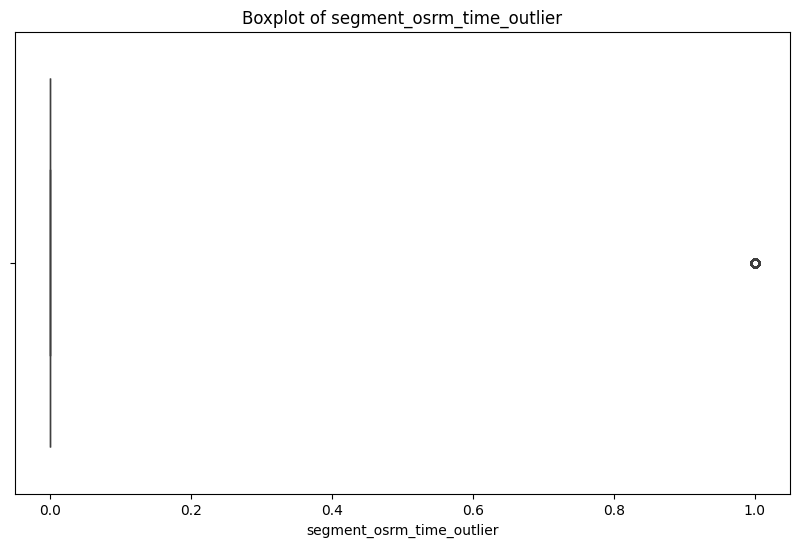

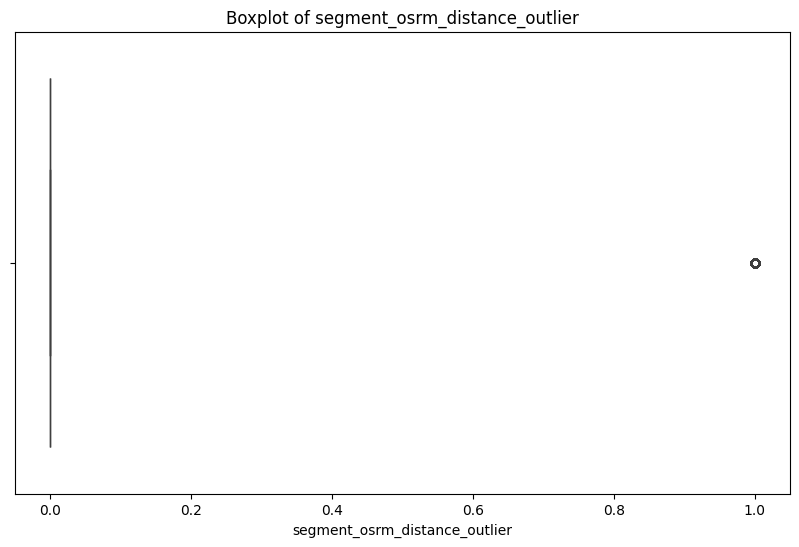

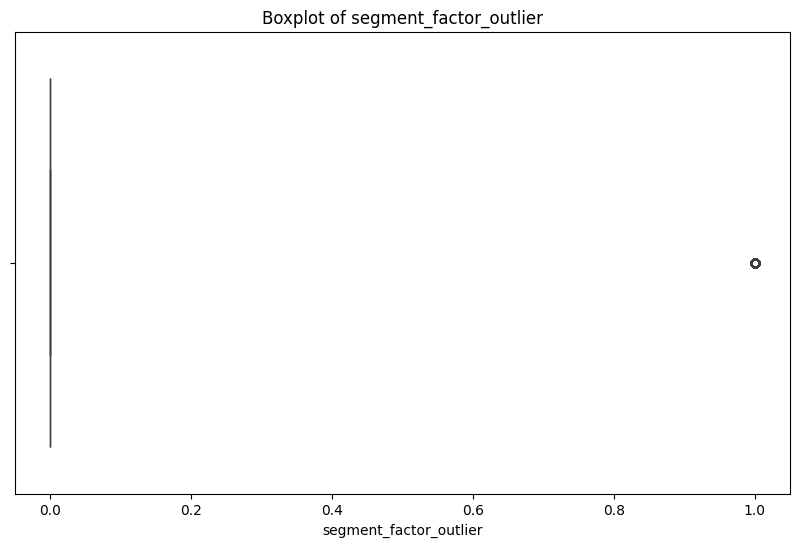

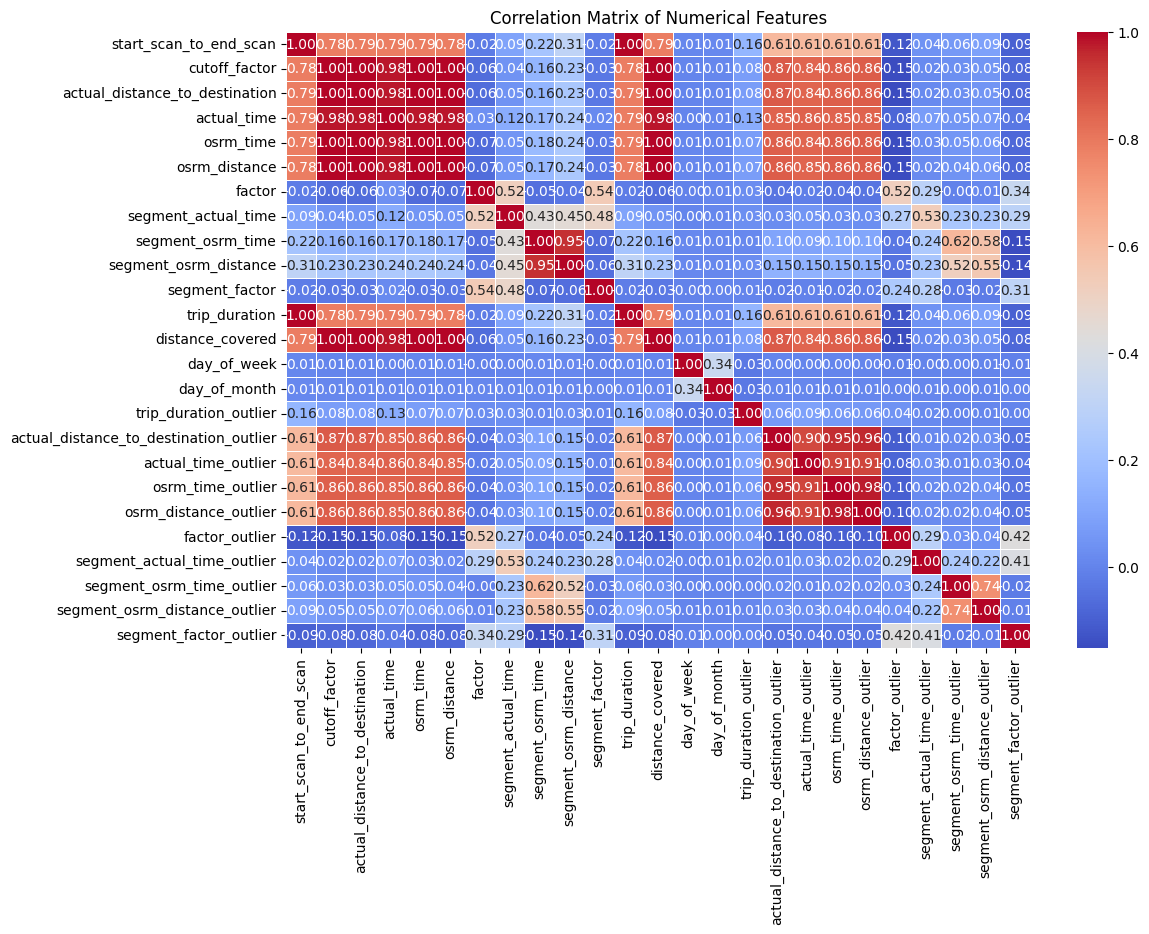

In [2]:
# Summarize the dataset
print("\nDataset Summary:")
print(df.describe())

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Sample data to speed up plotting (if needed)
sampled_df = df.sample(frac=0.1, random_state=42)  # 10% sample

# Plotting for categorical columns with limited categories (top 10 most frequent values)
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    top_categories = df[col].value_counts().nlargest(10)  # Get top 10 categories
    sns.countplot(y=df[col], order=top_categories.index)
    plt.title(f"Category Counts of {col}")
    plt.show()

# Identify outliers with boxplots for numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Correlation heatmap for numerical columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# feature engineering

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [4]:
# Handle Missing Values
# Impute missing values for continuous features using median
df['cutoff_timestamp'] = pd.to_datetime(df['cutoff_timestamp'], errors='coerce')
df['cutoff_timestamp_numeric'] = (df['cutoff_timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df['cutoff_timestamp_numeric'] = imputer.fit_transform(df[['cutoff_timestamp_numeric']])
df['cutoff_timestamp'] = pd.to_datetime(df['cutoff_timestamp_numeric'], unit='s')


In [5]:
# Handle Date and Time Features
# Convert timestamp columns to datetime
df['trip_creation_time'] = pd.to_datetime(df['trip_creation_time'])
df['od_start_time'] = pd.to_datetime(df['od_start_time'])
df['od_end_time'] = pd.to_datetime(df['od_end_time'])

# Create new time-based features (day of week, month, hour, etc.)
df['trip_creation_day_of_week'] = df['trip_creation_time'].dt.dayofweek
df['trip_creation_hour'] = df['trip_creation_time'].dt.hour
df['od_duration'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds() / 3600  # Convert to hours


In [6]:
# Create Derived Features
# Example: Calculate ratios between time-based and distance-based features
df['time_to_distance_ratio'] = df['actual_time'] / (df['actual_distance_to_destination'] + 1)  # Avoid division by zero
df['segment_time_to_distance_ratio'] = df['segment_actual_time'] / (df['segment_osrm_distance'] + 1)

# Example: Create interaction terms between features
df['actual_distance_to_osrm_ratio'] = df['actual_distance_to_destination'] / (df['osrm_distance'] + 1)


In [7]:
# Create new features from time columns
df['trip_duration'] = (df['od_end_time'] - df['od_start_time']).dt.total_seconds()  # in seconds
df['time_to_cutoff'] = (df['cutoff_timestamp'] - df['od_end_time']).dt.total_seconds()  # time to cutoff


In [8]:
# Categorize hours of day (Morning, Afternoon, Evening)
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    return 'Night'

df['time_of_day'] = df['trip_creation_hour'].apply(categorize_time_of_day)

# Weekday/Weekend feature (1 for weekend, 0 for weekday)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sum of outliers across different columns to create a combined outlier flag
df['outlier_count'] = (df[['trip_duration_outlier', 'factor_outlier', 'segment_actual_time_outlier', 
                            'segment_osrm_time_outlier', 'segment_osrm_distance_outlier', 
                            'segment_factor_outlier']] == 1).sum(axis=1)


In [9]:
# Feature Selection - Remove Irrelevant Features
# Drop columns that are less relevant to the model
df = df.drop(columns=['data', 'trip_uuid', 'route_schedule_uuid', 'source_name', 'destination_name'])


In [10]:
# One-hot encode categorical features (e.g., route_type, source_center, destination_center)
categorical_columns = ['route_type', 'source_center', 'destination_center', 'time_of_day']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [11]:
# Apply scaling to numerical features (e.g., factor, segment_factor, trip_duration)
numerical_columns = ['factor', 'segment_factor', 'trip_duration', 'time_to_cutoff', 'cutoff_timestamp_numeric']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
from tqdm import tqdm

def calculate_vif(numerical_df):
    """
    Calculate VIF for numerical columns.
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = numerical_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(numerical_df.values, i) for i in tqdm(range(numerical_df.shape[1]))
    ]
    return vif_data

# Retain the original dataframe
original_df = df.copy()

# Separate numerical and non-numerical columns
numerical_df = df.select_dtypes(include=[np.number])
non_numerical_df = df.select_dtypes(exclude=[np.number])

# Drop highly correlated columns (correlation > 0.9) from the numerical columns
corr_matrix = numerical_df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
numerical_df = numerical_df.drop(columns=to_drop)

# Drop rows with missing values in the numerical data
numerical_df = numerical_df.dropna()

# Calculate VIF for numerical columns
vif_data = calculate_vif(numerical_df)

# Print the VIF results
print("VIF Results:")
print(vif_data)

# Recombine numerical and non-numerical data
# Keep `is_cutoff` or other binary columns if needed
df = pd.concat([numerical_df, non_numerical_df], axis=1)

# Ensure there are no missing rows
df = df.dropna()

# Optional: Verify the shape of the final dataframe
print("Shape of the final dataframe:", df.shape)


 38%|███▊      | 8/21 [00:03<00:04,  2.75it/s]c:\Users\salma\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


VIF Results:
                                   feature        VIF
0                   start_scan_to_end_scan   5.431795
1                            cutoff_factor  10.385011
2                                   factor   1.886990
3                      segment_actual_time  15.561577
4                        segment_osrm_time   6.038265
5                           segment_factor   1.527535
6                              day_of_week  12.975243
7                             day_of_month   6.766706
8                    trip_duration_outlier        inf
9   actual_distance_to_destination_outlier   4.815581
10                          factor_outlier        inf
11             segment_actual_time_outlier        inf
12               segment_osrm_time_outlier        inf
13           segment_osrm_distance_outlier        inf
14                  segment_factor_outlier        inf
15                cutoff_timestamp_numeric   1.049278
16               trip_creation_day_of_week   9.203112
17             

In [13]:
df.columns

Index(['start_scan_to_end_scan', 'cutoff_factor', 'factor',
       'segment_actual_time', 'segment_osrm_time', 'segment_factor',
       'day_of_week', 'day_of_month', 'trip_duration_outlier',
       'actual_distance_to_destination_outlier',
       ...
       'destination_center_IND853204AAA', 'destination_center_IND854105AAA',
       'destination_center_IND854105AAB', 'destination_center_IND854311AAA',
       'destination_center_IND854326AAB', 'destination_center_IND854334AAA',
       'destination_center_IND854335AAA', 'time_of_day_Evening',
       'time_of_day_Morning', 'time_of_day_Night'],
      dtype='object', length=3017)

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Assuming `df` is your DataFrame and you want to predict `is_cutoff` (adjust if your target is different)
target_column = 'is_cutoff'

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]
datetime_columns = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_columns:
    X[col] = X[col].astype('int64') // 10**9  # Convert datetime to Unix timestamp

# Standardize numerical features before applying PCA and other methods
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analysis (PCA)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
print(f'Original shape: {X.shape}')
print(f'Shape after PCA: {X_pca.shape}')


Original shape: (144867, 3016)
Shape after PCA: (144867, 802)


In [15]:
# Feature Selection: Chi-Square (for categorical features)
# Select K best features based on chi-square test
chi2_selector = SelectKBest(chi2, k=10)  # Select top 10 features based on chi-square test
X_chi2 = chi2_selector.fit_transform(X_scaled, y)
print(f'Shape after Chi-Square feature selection: {X_chi2.shape}')



Shape after Chi-Square feature selection: (144867, 10)


In [16]:
# Feature Selection: ANOVA F-Value (for classification problems)
anova_selector = SelectKBest(f_classif, k=10)  # Select top 10 features based on ANOVA F-test
X_anova = anova_selector.fit_transform(X_scaled, y)
print(f'Shape after ANOVA feature selection: {X_anova.shape}')



Shape after ANOVA feature selection: (144867, 10)


In [17]:
# Embedded Methods: Lasso or Ridge regression (L1/L2 Regularization)
lasso = LassoCV(cv=5)
lasso.fit(X_scaled, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print(f'Selected features by Lasso: {lasso_selected_features}')

ridge = RidgeCV(cv=5)
ridge.fit(X_scaled, y)
ridge_selected_features = X.columns[ridge.coef_ != 0]
print(f'Selected features by Ridge: {ridge_selected_features}')

# Recursive Feature Elimination (RFE)
# Use a random forest model to evaluate feature importance during RFE
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
# X_rfe = rfe.fit_transform(X_scaled, y)
# print(f'Shape after RFE feature selection: {X_rfe.shape}')

# selected_features_rfe = X.columns[rfe.support_]
# print(f'Selected features by RFE: {selected_features_rfe}')



c:\Users\salma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2216575661132083, tolerance: 1.7303542595324886
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\salma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.323471947300277, tolerance: 1.7303542595324886
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\salma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.302231119985663, tolerance: 1.7159704600755883
  model = cd_fast.enet_coordinate_descent_gram(


Selected features by Lasso: Index(['start_scan_to_end_scan', 'cutoff_factor', 'factor',
       'segment_osrm_time', 'day_of_week', 'day_of_month',
       'trip_duration_outlier', 'actual_distance_to_destination_outlier',
       'factor_outlier', 'segment_actual_time_outlier',
       ...
       'destination_center_IND847226AAA', 'destination_center_IND847404AAB',
       'destination_center_IND848114AAA', 'destination_center_IND848210AAA',
       'destination_center_IND851204AAA', 'destination_center_IND852113AAA',
       'destination_center_IND854311AAA', 'destination_center_IND854326AAB',
       'time_of_day_Evening', 'time_of_day_Morning'],
      dtype='object', length=790)
Selected features by Ridge: Index(['start_scan_to_end_scan', 'cutoff_factor', 'factor',
       'segment_actual_time', 'segment_osrm_time', 'segment_factor',
       'day_of_week', 'day_of_month', 'trip_duration_outlier',
       'actual_distance_to_destination_outlier',
       ...
       'destination_center_IND853204

In [18]:
# Create a DataFrame to store all the feature selection results
reduced_features_df = pd.DataFrame({
    'Original Features': X.columns,
    'PCA Selected': ['Yes' if col in pca.components_.flatten()[:X.shape[1]].astype(int).tolist() else 'No' for col in X.columns],
    'Chi2 Selected': ['Yes' if col in chi2_selector.get_support() else 'No' for col in X.columns],
    'ANOVA Selected': ['Yes' if col in anova_selector.get_support() else 'No' for col in X.columns],
    'Lasso Selected': ['Yes' if col in lasso_selected_features else 'No' for col in X.columns],
    'Ridge Selected': ['Yes' if col in ridge_selected_features else 'No' for col in X.columns],
})

In [19]:
# Saving each feature selection set separately

# PCA: Since PCA returns transformed data, we need to save it with the corresponding selected feature columns
pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])
pca_df.to_csv('data\X_pca.csv', index=False)

# Chi-Square: Use the selected columns
chi2_selected_df = pd.DataFrame(X_scaled[:, chi2_selector.get_support()], columns=X.columns[chi2_selector.get_support()])
chi2_selected_df.to_csv('data\X_chi2_selected.csv', index=False)

# ANOVA: Use the selected columns
anova_selected_df = pd.DataFrame(X_scaled[:, anova_selector.get_support()], columns=X.columns[anova_selector.get_support()])
anova_selected_df.to_csv('data\X_anova_selected.csv', index=False)

# Lasso: Use the selected columns
lasso_selected_df = pd.DataFrame(X_scaled[:, lasso.coef_ != 0], columns=lasso_selected_features)
lasso_selected_df.to_csv('data\X_lasso_selected.csv', index=False)

# Ridge: Use the selected columns
ridge_selected_df = pd.DataFrame(X_scaled[:, ridge.coef_ != 0], columns=ridge_selected_features)
ridge_selected_df.to_csv('data\X_ridge_selected.csv', index=False)

# # RFE: Use the selected columns
# rfe_selected_df = pd.DataFrame(X_scaled[:, rfe.support_], columns=selected_features_rfe)
# rfe_selected_df.to_csv('data\X_rfe_selected.csv', index=False)

print("Feature selection results have been saved to separate CSV files.")

Feature selection results have been saved to separate CSV files.
